# Import & Read 


In [1]:
import numpy as np
import tensorflow as tf
import random as rn
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

In [3]:
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import tsfel as fe
import os

In [4]:
# path = 'C:/Users/Sohaila/OneDrive - Qatar University/Desalination Project/data/data in UF-RO system/'
path = 'Data/'
data_FE = pd.read_csv(path+'/features_dataset.csv',index_col=0)
data_TS = pd.read_csv(path+'/timeseries_dataset.csv',index_col=0)

### Backwash duration

In [5]:
consecutives = data_TS['cycle'].diff().ne(0).cumsum()
all_cycles = []
bw_dur = []
for group in data_TS.groupby(consecutives):
    all_cycles.append(group[1])
    bw_dur.append(group[1]['FE/FT-104'].gt(1).sum())

In [6]:
data_FE['bw_dur'] = bw_dur

# Data Pre-processing

In [7]:
# standardize dataset
def standardize_dataset(data, mean, std):
  std_data = []
  for i in range(len(data)):
      t = (data[i]-mean)/std
      std_data.append(t)
  return std_data
def inverse_standardize(data, mean, std):
  std_data = []
  for i in range(len(data)):
      t = (data[i]*std)+mean
      std_data.append(t)
  return std_data

In [8]:
data_FE_train = data_FE.iloc[0:7390]
TMP_norm_labels = list((np.array(range(0,72))).astype(str))
all_TMP_norm = np.concatenate(data_FE_train[TMP_norm_labels].values)
all_TMP_norm = all_TMP_norm[~np.isnan(all_TMP_norm)]
mean_y = np.mean(all_TMP_norm)
std_y = np.std(all_TMP_norm)

## TMP Decrease Model

In [9]:
cf = ['FE/FT-101', 'FE/FT-102', 'FE/FT-103','PT-101','Time', 'active_membranes', 'month','no_cycles','bw_dur']
df = ['input_tmp_balance', 'output_tmp_balance','auc_balance']
tsf = ['0_Spectral entropy','0_Wavelet energy_0', '0_Wavelet standard deviation_0', 
       '0_Mean','0_Median', '0_Area under the curve','0_Mean diff', 
       '0_Negative turning points','0_Skewness','0_ECDF Percentile_0',
       '0_Root mean square','0_Autocorrelation']

l_cf = np.array(range(0,len(cf)))
l_df = np.array(range(len(cf),len(cf)+len(df)))
l_tsf = np.array(range(len(cf)+len(df),len(cf)+len(df)+len(tsf)))

In [10]:
# for i in tsf:
#   plt.figure()
#   c = data_FE[i]
#   plt.plot(c)
#   plt.title('%s %.4f'%(i,np.var(c)))

In [11]:
y_labels = list((np.array(range(0,72,1))).astype(str))

In [12]:
last_tmp = [data_FE.iloc[i][y_labels].dropna().values[-1] for i in range(len(data_FE))]
flt_dur = [len(data_FE.iloc[i][y_labels].dropna().values) for i in range(len(data_FE))]

In [13]:
label = ['0']
x_train1 = data_FE[cf + df + tsf]
x_train1['flt_dur'] = flt_dur
x_train1['last_TMP'] = last_tmp

y_train1 = data_FE[label]

<ipython-input-13-2b1a77c0a390>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train1['flt_dur'] = flt_dur
<ipython-input-13-2b1a77c0a390>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train1['last_TMP'] = last_tmp


In [14]:
x_train1 = x_train1.iloc[0:-1]
y_train1 = y_train1.iloc[1:]

In [15]:
#splitting
X_train_TMP0 = x_train1.iloc[0:7390]
X_test_TMP0 = x_train1.iloc[7390:8824]
Y_train_TMP0 = y_train1.iloc[0:7390]
Y_test_TMP0 = y_train1.iloc[7390:8824]
# X_train_TMP0, X_test_TMP0, Y_train_TMP0, Y_test_TMP0 = train_test_split(x_train1,y_train1,test_size=0.371, random_state=42,shuffle=False)

In [16]:
x_scaler1 = StandardScaler()
y_scaler1 = StandardScaler()
X_train_TMP0_s = x_scaler1.fit_transform(X_train_TMP0)
X_test_TMP0_s = x_scaler1.transform(X_test_TMP0)
Y_train_TMP0_s = y_scaler1.fit_transform(Y_train_TMP0)
Y_test_TMP0_s = y_scaler1.transform(Y_test_TMP0)

In [17]:
X_train_TMP0_s, X_val_TMP0_s, Y_train_TMP0_s, Y_val_TMP0_s = train_test_split(X_train_TMP0_s,Y_train_TMP0_s,
                                                                              test_size=0.15,shuffle=False,random_state=1)

## TMP increase model

In [18]:
labels_tmp_increase = list((np.array(range(1,72,1))).astype(str))
x_train2 = data_FE[cf+df+tsf+label]
y_train2 = data_FE[labels_tmp_increase]

In [19]:
x_train2 = pd.concat((x_train2[cf].iloc[1:].reset_index(drop=True),
                      x_train2[df+tsf].iloc[0:-1],
                      x_train2[label].iloc[1:].reset_index(drop=True)),axis=1)
y_train2 = y_train2.iloc[1:]

In [20]:
X_train_TMP_all = x_train2.iloc[0:7390]
X_test_TMP_all = x_train2.iloc[7390:8824]
Y_train_TMP_all = y_train2.iloc[0:7390]
Y_test_TMP_all = y_train2.iloc[7390:8824]

In [21]:
x_scaler2 = StandardScaler()
X_train_TMP_all_s = x_scaler2.fit_transform(X_train_TMP_all)
X_test_TMP_all_s = x_scaler2.transform(X_test_TMP_all)

In [22]:
Y_train_TMP_all = [Y_train_TMP_all.iloc[i].dropna().values for i in range(len(Y_train_TMP_all))]
Y_test_TMP_all = [Y_test_TMP_all.iloc[i].dropna().values for i in range(len(Y_test_TMP_all))]

In [23]:
mean_y = np.mean(np.concatenate(Y_train_TMP_all))
std_y = np.std(np.concatenate(Y_train_TMP_all))
Y_train_TMP_all_s = standardize_dataset(Y_train_TMP_all, mean_y,std_y)
Y_test_TMP_all_s = standardize_dataset(Y_test_TMP_all, mean_y,std_y)

In [24]:
X_train_TMP_all_s, X_val_TMP_all_s, Y_train_TMP_all_s, Y_val_TMP_all_s = train_test_split(X_train_TMP_all_s,Y_train_TMP_all_s,
                                                                              test_size=0.15,shuffle=False,random_state=1)

In [25]:
len(X_train_TMP_all_s), len(X_train_TMP_all), len(Y_train_TMP_all_s), len(Y_train_TMP_all)

(6281, 7390, 6281, 7390)

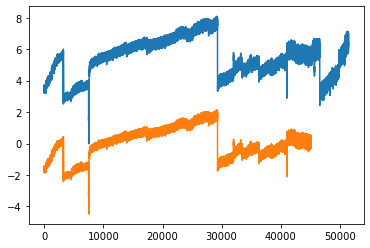

In [26]:
plt.plot(np.concatenate(Y_train_TMP_all))
plt.plot(np.concatenate(Y_train_TMP_all_s))

# Train

In [27]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_error, explained_variance_score
def evaluate(y_true,y_pred):
  print('RMSE: ',mean_squared_error(y_true,y_pred,squared=False))
  print('MSE: ',mean_squared_error(y_true,y_pred,squared=True))
  print('MAE: ',mean_absolute_error(y_true,y_pred))
  print('EVC: ',explained_variance_score(y_true,y_pred))
  print('R2: ',r2_score(y_true,y_pred))

## Initial TMP prediction model

In [28]:
units = 32
activation = 'selu'
initializer = tf.keras.initializers.LecunNormal(seed=42)
regularizer = tf.keras.regularizers.l1_l2(0.01)
drop = 0
input = tf.keras.layers.Input(shape=(X_train_TMP0.shape[1]))
layer1 = tf.keras.layers.Dense(units,activation,kernel_initializer=initializer,bias_initializer=initializer,activity_regularizer=regularizer,name='dense_layer1')(input)
layer1 = tf.keras.layers.AlphaDropout(drop,seed=42)(layer1)
layer2 = tf.keras.layers.Dense(units,activation,kernel_initializer=initializer,bias_initializer=initializer,activity_regularizer=regularizer,name='dense_layer2')(layer1)
layer2 = tf.keras.layers.AlphaDropout(drop,seed=42)(layer2)

dense_output = tf.keras.layers.Dense(1,kernel_initializer=initializer,bias_initializer=initializer,activity_regularizer=regularizer,name='dense_output')(layer2)

model_TMPD = tf.keras.Model(input,dense_output)


In [29]:
lr=0.001
monitor='loss'
factor = 0.2
nb_epoch = 150
batch_size = 128

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor, patience=10,
                                  factor=factor, cooldown=0, min_lr=1e-4, verbose=2)
early_stop = tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=15, verbose=2,restore_best_weights=False)
callback_list = [reduce_lr,early_stop]

model_TMPD.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse', metrics=['mae'])

In [30]:
history = model_TMPD.fit(X_train_TMP0_s,Y_train_TMP0_s, batch_size=batch_size, epochs=nb_epoch,verbose=1,shuffle=False)

Epoch 1/150
50/50 [==============================] - 1s 1ms/step - loss: 2.5848 - mae: 1.0301
Epoch 2/150
50/50 [==============================] - 0s 2ms/step - loss: 1.2399 - mae: 0.4010
Epoch 3/150
50/50 [==============================] - 0s 2ms/step - loss: 1.0126 - mae: 0.2632
Epoch 4/150
50/50 [==============================] - 0s 2ms/step - loss: 0.8965 - mae: 0.2088
Epoch 5/150
50/50 [==============================] - 0s 2ms/step - loss: 0.8153 - mae: 0.2023
Epoch 6/150
50/50 [==============================] - 0s 2ms/step - loss: 0.7658 - mae: 0.2034
Epoch 7/150
50/50 [==============================] - 0s 2ms/step - loss: 0.7063 - mae: 0.2014
Epoch 8/150
50/50 [==============================] - 0s 2ms/step - loss: 0.6868 - mae: 0.2409
Epoch 9/150
50/50 [==============================] - 0s 2ms/step - loss: 0.6990 - mae: 0.2882
Epoch 10/150
50/50 [==============================] - 0s 2ms/step - loss: 0.6832 - mae: 0.3343
Epoch 11/150
50/50 [==============================] - 0s 2m

In [32]:
# model_TMPD.save('C:/Users/Sohaila/OneDrive - Qatar University/Desalination Project/BWModel')
# model_TMPD = tf.keras.models.load_model('C:/Users/Sohaila/OneDrive - Qatar University/Desalination Project/BWModel')

In [33]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])

In [34]:
pred_train = model_TMPD.predict(X_train_TMP0_s)
pred_val = model_TMPD.predict(X_val_TMP0_s)
pred_test = model_TMPD.predict(X_test_TMP0_s)

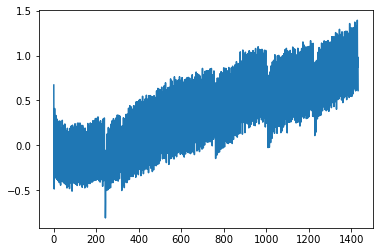

In [35]:
plt.plot(pred_test)

In [36]:
evaluate(y_scaler1.inverse_transform(Y_train_TMP0_s),y_scaler1.inverse_transform(pred_train))

RMSE:  0.24825310521046542
MSE:  0.061629604246638416
MAE:  0.18760037531137322
EVC:  0.9303608878782578
R2:  0.9281036427831284


In [37]:
evaluate(y_scaler1.inverse_transform(Y_val_TMP0_s),y_scaler1.inverse_transform(pred_val))

RMSE:  0.32161818117261176
MSE:  0.10343825446077892
MAE:  0.25805238959720267
EVC:  0.9256199375753424
R2:  0.8648124580672091


In [38]:
evaluate(Y_test_TMP0,y_scaler1.inverse_transform(pred_test))

RMSE:  0.13422400122845424
MSE:  0.018016082505776087
MAE:  0.10299752002030564
EVC:  0.869591771056631
R2:  0.8571279234032443


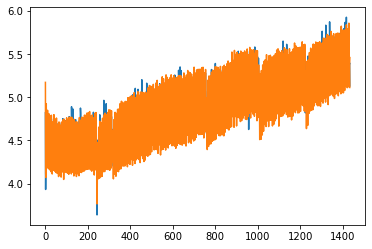

In [39]:
plt.plot(Y_test_TMP0.values)
plt.plot(y_scaler1.inverse_transform(pred_test))

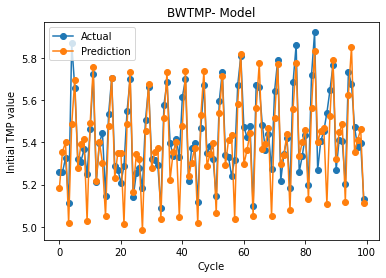

In [40]:
plt.plot(Y_test_TMP0.values[-100:],'o-',label='Actual')
plt.plot(y_scaler1.inverse_transform(pred_test)[-100:],'o-',label='Prediction')
plt.xlabel('Cycle')
plt.ylabel('Initial TMP value')
plt.title('BWTMP- Model')
plt.legend()

## TMP increase Model

In [41]:
class Autoregressive_Dense(tf.keras.Model):
  def __init__(self, units,n_layers,activation=None,reg=None,drop=0,init=None,b_init=None):
    super().__init__()
    self.units = units
    self.drop = drop
    self.n_layers = n_layers
    self.dense_layers = []
    self.activations = []
    self.drop_layers = []
    u = units
    for i in range(self.n_layers):
      self.dense_layers.append(tf.keras.layers.Dense(u,activity_regularizer=reg,kernel_initializer=init,bias_initializer=b_init,name='dense_'+str(i)))
      self.activations.append(tf.keras.layers.Activation(activation,name='activation_'+str(i)))
      self.drop_layers.append(tf.keras.layers.Dropout(self.drop,seed=42,name='drop_'+str(i)))
#       u = units/2

    self.dense_output = tf.keras.layers.Dense(1,kernel_initializer=init,bias_initializer=b_init,activity_regularizer=reg,name='dense_output')

  def network(self, inputs): 
    x = self.dense_layers[0](inputs)
    x = self.activations[0](x)
    x = self.drop_layers[0](x)
    for i in range(1,self.n_layers):
      x = self.dense_layers[i](x)
      x = self.activations[i](x)
      x = self.drop_layers[i](x)

    prediction = self.dense_output(x)
    return prediction

  def call(self, inputs):
    predictions = []
    x_variables = inputs[0] ##(batch,num_features)
    x_tmp = inputs[1] ## (batch,1)
    out_steps = inputs[2]
    a = np.zeros((x_tmp.shape[0],1))
    a = (a-np.mean(range(0,25)))/np.std(range(0,25))
    x = tf.concat([x_variables,x_tmp,a],axis=-1) ##(batch,num_features+1)
    prediction = self.network(x)
    predictions.append(prediction)

    # Run the rest of the prediction steps.
    for n in range(1, tf.cast(out_steps,tf.int32)):
      a = np.zeros((x_tmp.shape[0],1))
      a.fill(n)
      a = (a-np.mean(range(0,25)))/np.std(range(0,25))
      # print(a)
      # a = tf.Variable(a,dtype=tf.float32)
      x = tf.concat([x_variables,prediction,a],axis=-1)
      
      prediction = self.network(x)

      predictions.append(prediction)

    predictions = tf.stack(predictions)

    return predictions

In [42]:
model_TMPI = Autoregressive_Dense(units=64,n_layers=2,activation=tf.keras.layers.ReLU(),reg=tf.keras.regularizers.l1_l2(0.01),drop=0,
                             init=tf.keras.initializers.GlorotNormal(seed=42),b_init=tf.keras.initializers.GlorotNormal(seed=42))

In [43]:
optimizer = tf.keras.optimizers.Adam(0.001)
loss_fn = tf.keras.losses.MeanSquaredError()
train_acc_metric1 = tf.keras.metrics.MeanSquaredError()
train_acc_metric2 = tf.keras.metrics.MeanAbsoluteError()
train_acc_metric3 = tf.keras.metrics.MeanAbsolutePercentageError()
val_acc_metric = tf.keras.metrics.MeanSquaredError()

In [44]:
tf.config.list_physical_devices('GPU')

[]

# Train

In [45]:
epochs = 100
batch = 256
val_loss = []
X_train_s, Y_train_s = X_train_TMP_all_s, Y_train_TMP_all_s

for epoch in range(epochs):
    print("Start of epoch %d/%d" % (epoch,epochs))
    # X_train_s, Y_train_s = sklearn.utils.shuffle(X_train_s, Y_train_s)
    for i in range(0,len(X_train_s)-batch,batch):

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        out_steps = np.min([len(Y_train_s[j]) for j in range(i,i+batch)])
        x1 = X_train_s[i:i+batch,0:-1]
        x2 = np.expand_dims(X_train_s[i:i+batch,-1],axis=1)
        output = [y[0:out_steps] for y in Y_train_s[i:i+batch]]
        output = np.expand_dims(np.transpose(output),axis=-1)
        with tf.GradientTape() as tape:
            # Run the forward pass of the layer.
            logits = model_TMPI([x1,x2,out_steps], training=True)  # Logits for this minibatch
            # Compute the loss value for this minibatch.
            loss_value = loss_fn(output, logits)

        # Use the gradient tape to automatically retrieve the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model_TMPI.trainable_weights)
        # Run one step of gradient descent by updating the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model_TMPI.trainable_weights))
        # Update the training metrics
        train_acc_metric1.update_state(output, logits)
        train_acc_metric2.update_state(output, logits)
        train_acc_metric3.update_state(output, logits)

    train_acc1 = train_acc_metric1.result()
    train_acc2 = train_acc_metric2.result()
    train_acc3 = train_acc_metric3.result()
    print("Loss: %.4f, Training metrics: MSE: %.4f, MAE: %.4f, MAPE: %.4f" % (float(loss_value),float(train_acc1),float(train_acc2),float(train_acc3)))

    # Reset training metrics at the end of each epoch
    train_acc_metric1.reset_states()
    train_acc_metric2.reset_states()
    train_acc_metric3.reset_states()


Start of epoch 0/100
Loss: 0.3320, Training metrics: MSE: 2.5716, MAE: 1.3833, MAPE: 1074.0089
Start of epoch 1/100
Loss: 0.0974, Training metrics: MSE: 0.9288, MAE: 0.7333, MAPE: 346.5338
Start of epoch 2/100
Loss: 0.1073, Training metrics: MSE: 0.2093, MAE: 0.3420, MAPE: 280.7522
Start of epoch 3/100
Loss: 0.1208, Training metrics: MSE: 0.1037, MAE: 0.2294, MAPE: 230.4704
Start of epoch 4/100
Loss: 0.0856, Training metrics: MSE: 0.0696, MAE: 0.1893, MAPE: 187.1152
Start of epoch 5/100
Loss: 0.0753, Training metrics: MSE: 0.0518, MAE: 0.1647, MAPE: 165.1290
Start of epoch 6/100
Loss: 0.0688, Training metrics: MSE: 0.0410, MAE: 0.1474, MAPE: 136.0173
Start of epoch 7/100
Loss: 0.0641, Training metrics: MSE: 0.0342, MAE: 0.1345, MAPE: 126.4612
Start of epoch 8/100
Loss: 0.0601, Training metrics: MSE: 0.0307, MAE: 0.1272, MAPE: 105.9984
Start of epoch 9/100
Loss: 0.0572, Training metrics: MSE: 0.0280, MAE: 0.1214, MAPE: 107.2613
Start of epoch 10/100
Loss: 0.0543, Training metrics: MSE: 

Loss: 0.0203, Training metrics: MSE: 0.0167, MAE: 0.0968, MAPE: 79.6543
Start of epoch 88/100
Loss: 0.0189, Training metrics: MSE: 0.0179, MAE: 0.0970, MAPE: 73.0958
Start of epoch 89/100
Loss: 0.0285, Training metrics: MSE: 0.0258, MAE: 0.1316, MAPE: 120.6253
Start of epoch 90/100
Loss: 0.0200, Training metrics: MSE: 0.0260, MAE: 0.1270, MAPE: 158.7802
Start of epoch 91/100
Loss: 0.0217, Training metrics: MSE: 0.0259, MAE: 0.1226, MAPE: 144.4927
Start of epoch 92/100
Loss: 0.0201, Training metrics: MSE: 0.0195, MAE: 0.1081, MAPE: 77.7238
Start of epoch 93/100
Loss: 0.0186, Training metrics: MSE: 0.0237, MAE: 0.1169, MAPE: 88.1906
Start of epoch 94/100
Loss: 0.0330, Training metrics: MSE: 0.0398, MAE: 0.1689, MAPE: 167.0446
Start of epoch 95/100
Loss: 0.0222, Training metrics: MSE: 0.0381, MAE: 0.1598, MAPE: 204.5831
Start of epoch 96/100
Loss: 0.0199, Training metrics: MSE: 0.0388, MAE: 0.1528, MAPE: 179.6231
Start of epoch 97/100
Loss: 0.0221, Training metrics: MSE: 0.0291, MAE: 0.13

In [46]:
# model.save_weights('C:/Users/Sohaila/OneDrive - Qatar University/Desalination Project/ARModel.h5')
# model_TMPI.load_weights('C:/Users/Sohaila/OneDrive - Qatar University/Desalination Project/ARModel.h5')

In [47]:
# pred_train = []
# for i in range(len(X_train_TMP_all_s)-1):
#   p = model([X_train_TMP_all_s[i:i+1,0:-1],np.expand_dims(X_train_TMP_all_s[i:i+1,-1],axis=1),len(Y_train_TMP_all_s[i])],training=False)
#   try:
#     pred_train.append(inverse_standardize(np.squeeze(p.numpy()),mean_y,std_y))
#   except:
#     pred_train.append([(np.squeeze(p.numpy())*std_y)+mean_y])

In [48]:
# evaluate(np.concatenate(Y_train_TMP_all)[0:len(np.concatenate(pred_train))],np.concatenate(pred_train))

In [49]:
# plt.plot(np.concatenate(Y_train_TMP_all))
# plt.plot(np.concatenate(pred_train))

In [50]:
pred_val = []
for i in range(len(X_val_TMP_all_s)):
  p = model_TMPI([X_val_TMP_all_s[i:i+1,0:-1],np.expand_dims(X_val_TMP_all_s[i:i+1,-1],axis=1),len(Y_val_TMP_all_s[i])],training=False)
  try:
    pred_val.append(inverse_standardize(np.squeeze(p.numpy()), mean_y,std_y))
  except TypeError:
    pred_val.append([(np.squeeze(p.numpy())*std_y)+mean_y])

In [51]:
evaluate(inverse_standardize(np.concatenate(Y_val_TMP_all_s), mean_y,std_y),np.concatenate(pred_val))

RMSE:  0.49318413135274014
MSE:  0.24323058741815684
MAE:  0.38358360166364097
EVC:  0.8727759150205736
R2:  0.7980347806562788


In [52]:
pred_test = []
for i in range(len(X_test_TMP_all_s)):
  p = model_TMPI([X_test_TMP_all_s[i:i+1,0:-1],np.expand_dims(X_test_TMP_all_s[i:i+1,-1],axis=1),len(Y_test_TMP_all_s[i])],training=False)
  try:
    pred_test.append(inverse_standardize(np.squeeze(p.numpy()), mean_y,std_y))
  except TypeError:
    pred_test.append([(np.squeeze(p.numpy())*std_y)+mean_y])

In [53]:
evaluate(np.concatenate(Y_test_TMP_all),np.concatenate(pred_test))

RMSE:  0.31498390830294337
MSE:  0.09921486248979704
MAE:  0.25700241045658284
EVC:  0.6398819376613802
R2:  0.6239937246404503


Text(0.5, 0, 'Filtration duration (2 min)')

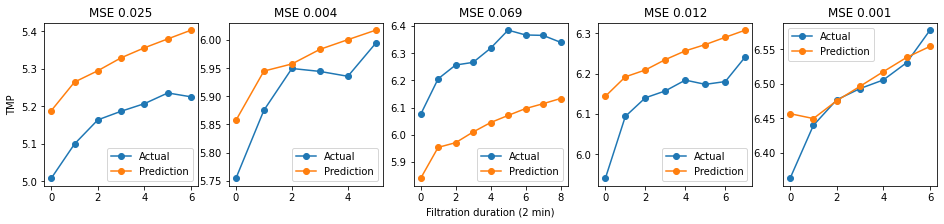

In [54]:
index = np.array([107, 915, 1307, 1358, 1169])

i = 0
fig, ax = plt.subplots(1,5,figsize=(16,3))
for a in ax:
#     for aa in a:
        n = index[i]
        a.plot(Y_test_TMP_all[n],'o-',label='Actual')
        a.plot(pred_test[n],'o-',label='Prediction')
        a.legend()
        a.set_title('MSE %0.3f'%(np.round(mean_squared_error(Y_test_TMP_all[n],pred_test[n],squared=True),decimals=3)))
        i += 1
ax[0].set_ylabel('TMP') 
ax[2].set_xlabel('Filtration duration (2 min)')       

Text(0.5, 0, 'Filtration duration (2 min)')

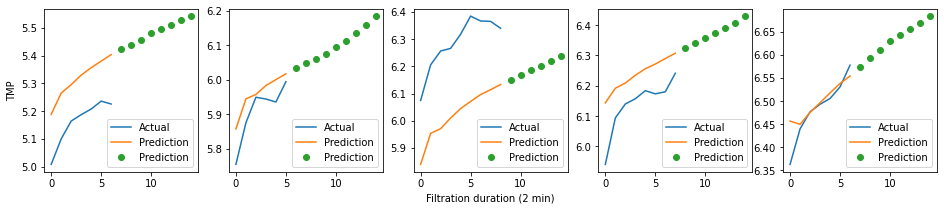

In [55]:
index = np.array([107, 915, 1307, 1358, 1169])

i = 0
fig, ax = plt.subplots(1,5,figsize=(16,3))
for a in ax:
#     for aa in a:
        n = index[i]
        a.plot(Y_test_TMP_all[n],'-',label='Actual')
        p = model_TMPI([X_test_TMP_all_s[n:n+1,0:-1],np.expand_dims(X_test_TMP_all_s[n:n+1,-1],axis=1),15],training=False)
        p = inverse_standardize(np.squeeze(p.numpy()), mean_y,std_y)
        a.plot(p[0:len(Y_test_TMP_all[n])],'-',label='Prediction')
        x = range(len(Y_test_TMP_all[n]),len(p))
        a.plot(x,p[len(Y_test_TMP_all[n]):],'o',label='Prediction')
        a.legend()
        i += 1
ax[0].set_ylabel('TMP') 
ax[2].set_xlabel('Filtration duration (2 min)')  

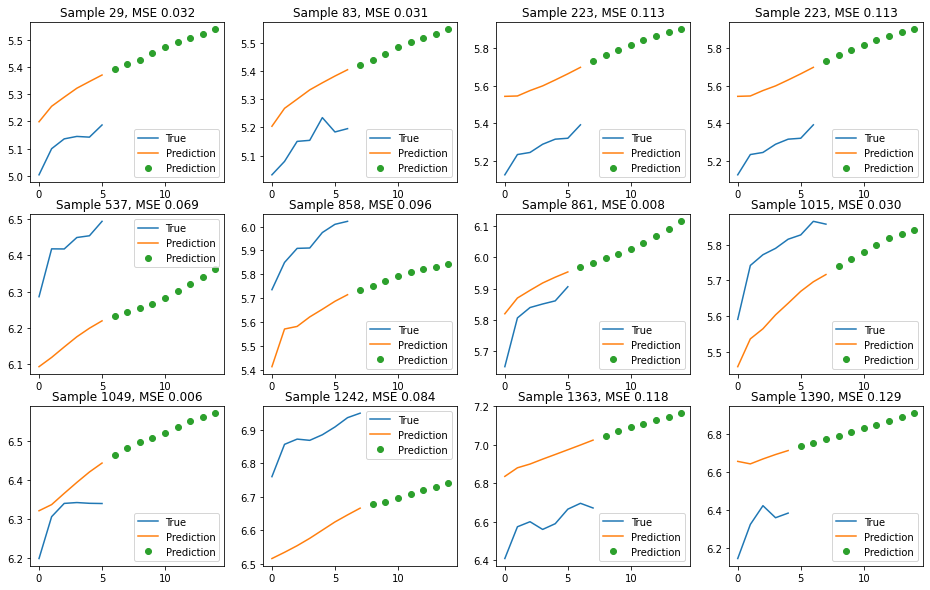

In [56]:
index = (np.random.rand(12)*len(Y_test_TMP_all)).astype(int)
index = np.sort(index)

i = 0
fig, ax = plt.subplots(3,4,figsize=(16,10))
for a in ax:
    for aa in a:
        n = index[i]
        aa.plot(Y_test_TMP_all[n],'-',label='True')
        p = model_TMPI([X_test_TMP_all_s[n:n+1,0:-1],np.expand_dims(X_test_TMP_all_s[n:n+1,-1],axis=1),15],training=False)
        p = inverse_standardize(np.squeeze(p.numpy()), mean_y,std_y)
        aa.plot(p[0:len(Y_test_TMP_all[n])],'-',label='Prediction')
        x = range(len(Y_test_TMP_all[n]),len(p))
        aa.plot(x,p[len(Y_test_TMP_all[n]):],'o',label='Prediction')
        aa.legend()
        aa.set_title('Sample %d, MSE %0.3f'%(n,np.round(mean_squared_error(Y_test_TMP_all[n],p[0:len(Y_test_TMP_all[n])],squared=True),decimals=3)))
        i += 1

# The two models

In [57]:
from tsfel import feature_extraction as fe
import tsfel

In [58]:
def find_domain_features(cycles):
    input_tmp_diff = []
    output_tmp_diff = []
    prev_tmp = [0,0]
    prev_auc = 0
    auc_diff = []
    auc_cycle = []
    for cycle in cycles:
        e = -1
        output_tmp_diff.append(cycle[e] - prev_tmp[1])
        input_tmp_diff.append(cycle[0] - prev_tmp[0])
        prev_tmp = [cycle[0],cycle[e]]
        auc_cycle.append(np.trapz(cycle[0:6]) - prev_auc)
        prev_auc = np.trapz(cycle[0:6])

    input_tmp_balance = np.cumsum(input_tmp_diff)
    output_tmp_balance = np.cumsum(output_tmp_diff)
    auc_balance = np.cumsum(auc_cycle)
    return input_tmp_balance[-1],output_tmp_balance[-1], auc_balance[-1]

In [59]:
def find_ts_features(data_window):
  fs=0.0083
  spectral_entropy = fe.spectral_entropy(data_window,fs)
  rms = fe.rms(data_window)
  skewness = fe.skewness(data_window)
  mean_diff = fe.mean_diff(data_window)
  neg_turning_points = fe.negative_turning(data_window)
  auc = fe.auc(data_window,fs)
  median = fe.calc_median(data_window)
  mean = fe.calc_mean(data_window)
  autocorrelation = fe.autocorr(data_window)
#   neighbourhood_peaks = fe.neighbourhood_peaks(data_window)
  ECDF_percentile = fe.ecdf_percentile(data_window)[0]
  wavelet_standard_deviation = fe.wavelet_std(data_window)[0]
  wavelet_energy = fe.wavelet_energy(data_window)[0]
#   pos_turning_points = fe.positive_turning(data_window)
  return spectral_entropy, wavelet_energy, wavelet_standard_deviation, mean, median, auc,mean_diff, neg_turning_points, skewness,ECDF_percentile, rms, autocorrelation 

In [60]:
consecutives = data_TS['cycle'].diff().ne(0).cumsum()
all_cycles = []
for group in data_TS.groupby(consecutives):
    all_cycles.append(group[1]['TMP_norm'].values)

In [61]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [62]:
s = 1
TMP_TS_cycle = all_cycles[0:len(Y_train_TMP0)+s]
TMP_TS_all = list(np.concatenate(all_cycles[0:len(Y_train_TMP0)+s]))
x_cf = X_test_TMP0_s[s,l_cf]
x_df = X_test_TMP0_s[s,l_df]
x_tsf = X_test_TMP0_s[s,l_tsf] 
flt = np.array([X_test_TMP0_s[s,-2]]) 
x_last_tmp = np.array([X_test_TMP0_s[s,-1] ])
X_model1 = np.expand_dims(np.concatenate((x_cf,x_df,x_tsf,flt,x_last_tmp)),axis=0)
tmp_test_results = []
x_tsf_results = []
for i in range(s,len(X_test_TMP0_s)):
  initial_TMP = model_TMPD.predict(X_model1)
  #update features for model 2
  x_cf = X_test_TMP_all_s[i,l_cf]       #scaled
  tmp0 = np.squeeze(initial_TMP,axis=1)                    #scaled
  print(i,tmp0)
  #construct input for model2
  X_model2 = np.concatenate((x_cf,x_df,x_tsf,tmp0))

  tmp_all = model_TMPI([np.expand_dims(X_model2[0:-1],axis=0),
                   np.expand_dims(np.array([X_model2[-1]]),axis=0),len(Y_test_TMP_all_s[i])],training=False)

  tmp_cycle_s = inverse_standardize(np.squeeze(tmp_all.numpy()), mean_y,std_y)
  tmp0_i = y_scaler1.inverse_transform(tmp0.reshape(1, -1))
  #concat model1 & model2 outputs
  # try:
    # tmp_cycle_s = np.concatenate((tmp0,np.squeeze(tmp_all.numpy())))
  tmp_cycle = np.concatenate((np.squeeze(tmp0_i,axis=0),np.array(tmp_cycle_s)))
  # except:
  # tmp_cycle = np.concatenate((tmp0_i,(np.squeeze(tmp_cycle_s,axis=(0,-1)))))
  #inverse scale
  # tmp_cycle = inverse_standardize(tmp_cycle_s, mean_y,std_y)
  tmp_test_results.append(tmp_cycle)
  #compute new features
  TMP_TS_cycle.append(np.array(tmp_cycle))
  TMP_TS_all.extend(tmp_cycle)
  x_cf = X_test_TMP_all.iloc[i,l_cf].values
  x_df = find_domain_features(TMP_TS_cycle)       #not scaled
  x_tsf = find_ts_features(np.array(TMP_TS_all))  #not scaled
  # x_tsf = np.array([x_tsf])
  flt = np.array([len(tmp_all)+1])                  #not scaled
  x_last_tmp = np.array([tmp_cycle[-1]])
  x_tsf_results.append(x_tsf)
  #scale
  X_scaled = x_scaler1.transform(np.concatenate((x_cf,x_df,x_tsf,flt,x_last_tmp)).reshape(1, -1))
  x_df = X_scaled[0,l_df]
  x_tsf = X_scaled[0,l_tsf]
  X_model1 = X_scaled


1 [-0.43146807]
2 [-0.35118735]
3 [-0.23173434]
4 [-0.08427888]
5 [-0.24076271]
6 [-0.11463773]
7 [-0.06286591]
8 [-0.15888453]
9 [-0.01740271]
10 [0.06142813]
11 [-0.10837936]
12 [0.03389019]
13 [0.03051198]
14 [-0.07829076]
15 [0.04866403]
16 [0.11156392]
17 [-0.05187136]
18 [0.04020703]
19 [0.07933003]
20 [-0.06488889]
21 [0.0674215]
22 [0.11560714]
23 [-0.06798613]
24 [0.07573819]
25 [0.08592802]
26 [-0.0932247]
27 [0.06452602]
28 [0.11329651]
29 [-0.06609976]
30 [0.03992939]
31 [0.04753697]
32 [-0.11306727]
33 [0.04716563]
34 [0.06874424]
35 [-0.06149119]
36 [0.06465036]
37 [0.0503993]
38 [-0.05915689]
39 [0.06352025]
40 [0.12746906]
41 [-0.028844]
42 [0.05919564]
43 [0.06921822]
44 [-0.04677248]
45 [0.07912689]
46 [0.0977633]
47 [-0.03120798]
48 [0.09510416]
49 [0.07211304]
50 [-0.04038846]
51 [0.09034765]
52 [0.13801804]
53 [-0.01499528]
54 [0.07151496]
55 [0.07014805]
56 [-0.06445593]
57 [0.10293782]
58 [0.08817708]
59 [-0.02337885]
60 [0.08786625]
61 [0.10380459]
62 [-0.073396

493 [0.4116025]
494 [0.2239697]
495 [0.46457392]
496 [0.49388567]
497 [0.3421126]
498 [0.41182107]
499 [0.44004527]
500 [0.24703279]
501 [0.4105292]
502 [0.4507314]
503 [0.26302803]
504 [0.4188346]
505 [0.42904115]
506 [0.31739792]
507 [0.4275427]
508 [0.49117893]
509 [0.36187568]
510 [0.38287234]
511 [0.47105616]
512 [0.24908382]
513 [0.4199372]
514 [0.45136335]
515 [0.30267036]
516 [0.39902622]
517 [0.43451816]
518 [0.28469077]
519 [0.4910954]
520 [0.5155185]
521 [0.3651311]
522 [0.48370615]
523 [0.46850267]
524 [0.27752388]
525 [0.43775225]
526 [0.5205331]
527 [0.32524204]
528 [0.4471741]
529 [0.4861669]
530 [0.2323896]
531 [0.4594366]
532 [0.4727534]
533 [0.33740485]
534 [0.44393465]
535 [0.48381692]
536 [0.35116497]
537 [0.4544723]
538 [0.46521324]
539 [0.27552387]
540 [0.40426028]
541 [0.43451872]
542 [0.2570938]
543 [0.4272595]
544 [0.42455855]
545 [0.29916072]
546 [0.42796177]
547 [0.4728431]
548 [0.27685404]
549 [0.44864994]
550 [0.5072316]
551 [0.33150014]
552 [0.44903743]
55

991 [0.7620432]
992 [0.7708086]
993 [0.6410638]
994 [0.7543516]
995 [0.72182137]
996 [0.6071317]
997 [0.7736605]
998 [0.8080637]
999 [0.6779415]
1000 [0.7321249]
1001 [0.7179127]
1002 [0.6446414]
1003 [0.7784975]
1004 [0.7320735]
1005 [1.1797236]
1006 [0.7561259]
1007 [0.77646375]
1008 [0.767066]
1009 [0.64507884]
1010 [0.77571887]
1011 [0.7626782]
1012 [0.6589431]
1013 [0.71259254]
1014 [0.6780915]
1015 [0.57669914]
1016 [0.7656989]
1017 [0.7620233]
1018 [0.6932711]
1019 [0.72581893]
1020 [0.6930512]
1021 [0.6277615]
1022 [0.7424105]
1023 [0.796983]
1024 [0.69930553]
1025 [0.72595733]
1026 [0.7226465]
1027 [0.6342117]
1028 [0.75170666]
1029 [0.8052795]
1030 [0.67737067]
1031 [0.7432328]
1032 [0.75010806]
1033 [0.6904669]
1034 [0.79854715]
1035 [0.78312457]
1036 [0.67745155]
1037 [0.7284882]
1038 [0.75700796]
1039 [0.68204]
1040 [0.79428387]
1041 [0.8420569]
1042 [0.7254214]
1043 [0.7872121]
1044 [0.7507313]
1045 [0.7012441]
1046 [0.7774211]
1047 [0.7896904]
1048 [0.6815163]
1049 [0.79

In [63]:
evaluate(np.concatenate(all_cycles[len(Y_train_TMP0)+s+1:len(Y_train_TMP0)+s+1+len(tmp_test_results)]),np.concatenate(tmp_test_results))
# evaluate(np.concatenate(Y_test_TMP_all[0:100]),np.concatenate(tmp_test_results))

RMSE:  0.33198446888034705
MSE:  0.1102136875777661
MAE:  0.25985279376288173
EVC:  0.776711691097922
R2:  0.7006264500120205


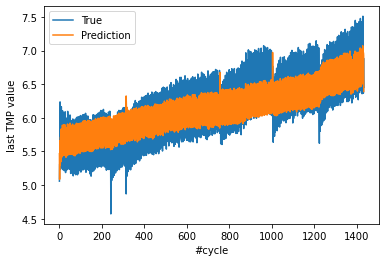

In [64]:
plt.plot([y[-1] for y in all_cycles[len(Y_train_TMP0)+s:len(Y_train_TMP0)+s+len(tmp_test_results)]],label='True')
plt.plot([y[-1] for y in tmp_test_results],label='Prediction')
plt.ylabel('last TMP value')
plt.xlabel('#cycle')
plt.legend()

In [65]:
last_tmp_true = np.array([y[-1] for y in all_cycles[len(Y_train_TMP0)+1+s:len(Y_train_TMP0)+s+1+len(tmp_test_results)]])
last_tmp_pred = np.array([y[-1] for y in tmp_test_results])
initial_tmp_true = np.array([y[0] for y in all_cycles[len(Y_train_TMP0)+1+s:len(Y_train_TMP0)+s+1+len(tmp_test_results)]])
initial_tmp_pred = np.array([y[0] for y in tmp_test_results])

In [66]:
x = np.array(range(0,len(last_tmp_true)))
y = last_tmp_true
m, b = np.polyfit(x, y, 1)
y2 = last_tmp_pred
m2, b2 = np.polyfit(x, y2, 1)

In [67]:
x = np.array(range(0,len(last_tmp_true)))
y_i = initial_tmp_true
m_i, b_i = np.polyfit(x, y_i, 1)
y2_i = initial_tmp_pred
m2_i, b2_i = np.polyfit(x, y2_i, 1)

In [68]:
mean_squared_error(m*x + b,m2*x + b2,squared=True)

0.03156094989394649

In [69]:
mean_squared_error(m_i*x + b_i,m2_i*x + b2_i,squared=True)

0.017034877463271352

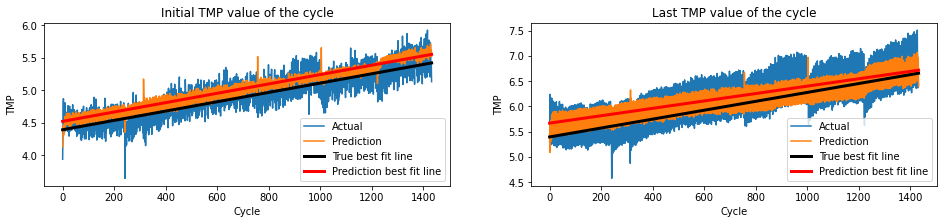

In [70]:
# index = (np.random.rand(12)*len(Y_test_TMP_all)).astype(int)
# index = np.sort(index)
i = 0
fig, ax = plt.subplots(1,2,figsize=(16,3))
ax[0].plot(initial_tmp_true,'-',label='Actual')
ax[0].plot(initial_tmp_pred,'-',label='Prediction')
ax[0].set_xlabel('Cycle')
ax[0].set_ylabel('TMP')
ax[0].plot(x, m_i*x + b_i,'k-',label='True best fit line',linewidth=3.0)
ax[0].plot(x, m2_i*x + b2_i,'r-',label='Prediction best fit line',linewidth=3.0)
ax[0].set_title('Initial TMP value of the cycle')
ax[0].legend()

ax[1].plot(last_tmp_true,'-',label='Actual')
ax[1].plot(last_tmp_pred,'-',label='Prediction')
ax[1].set_xlabel('Cycle')
ax[1].set_ylabel('TMP')
ax[1].plot(x, m*x + b,'k-',label='True best fit line',linewidth=3.0)
ax[1].plot(x, m2*x + b2,'r-',label='Prediction best fit line',linewidth=3.0)
ax[1].set_title('Last TMP value of the cycle')
ax[1].legend()

Text(0.5, 0, 'Cycle duration (2 min)')

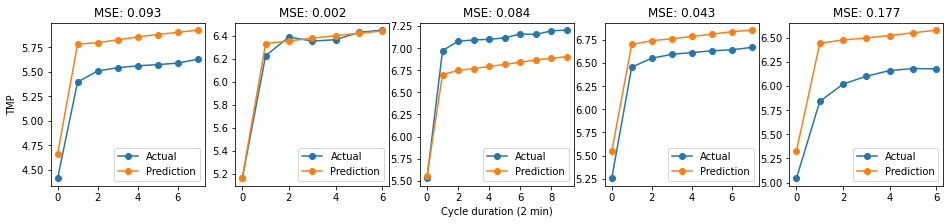

In [71]:
index = np.array([107, 915, 1307, 1358, 1169])

i = 0
fig, ax = plt.subplots(1,5,figsize=(16,3))
for a in ax:
#     for aa in a:
        n = index[i]
        x = all_cycles[len(Y_train_TMP0)+n+1+s]
        a.plot(x,'o-',label='Actual')
        a.plot(tmp_test_results[n],'o-',label='Prediction')
        a.legend()
        a.set_title('MSE: %.3f'%(np.round(mean_squared_error(x,tmp_test_results[n][0:len(x)],squared=True),decimals=3)))
        i += 1
ax[0].set_ylabel('TMP') 
ax[2].set_xlabel('Cycle duration (2 min)')  

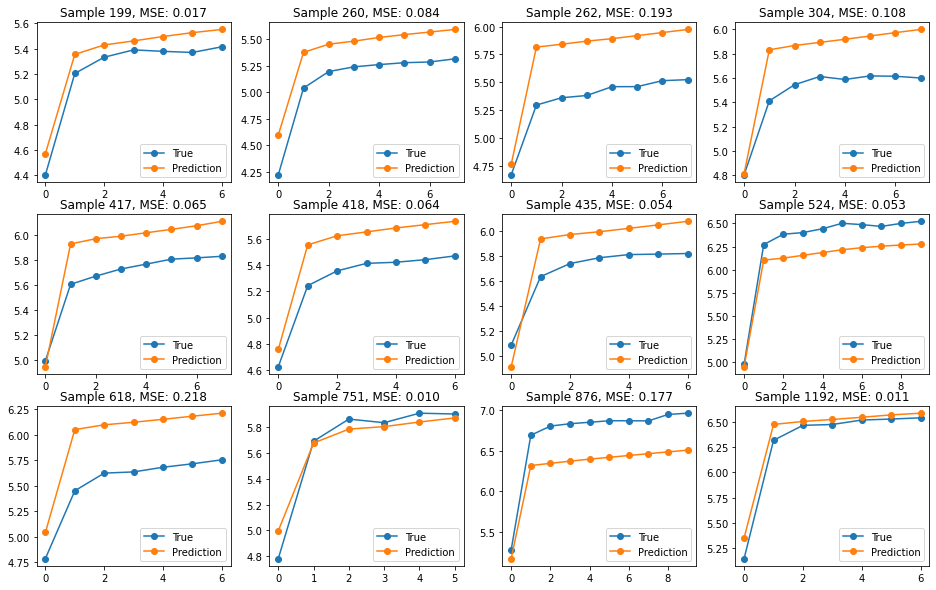

In [72]:
index = (np.random.rand(12)*len(tmp_test_results)).astype(int)
index = np.sort(index)
i = 0
fig, ax = plt.subplots(3,4,figsize=(16,10))
for a in ax:
    for aa in a:
        n = index[i]
        x = all_cycles[len(Y_train_TMP0)+n+1+s]
        aa.plot(x,'o-',label='True')
        # aa.plot(tmp_test_results_i[n],'o-',label='Prediction')
        # x = range(len(Y_test_TMP_all[n]),len(p))
        aa.plot(tmp_test_results[n],'o-',label='Prediction')
        aa.legend()
        aa.set_title('Sample %d, MSE: %.3f'%(n,np.round(mean_squared_error(x,tmp_test_results[n][0:len(x)],squared=True),decimals=3)))
        i += 1